# Azimuthally Random orientation

We first import all necessary packages. 

In [1]:
import bempp.api
import numpy as np

import time
from iterative_solvers import gmres, get_h
from operators import PMCHWT_operator, PMCHWT_preconditioner, mass_matrix_BC_SNC
from multiprocessing import Pool, cpu_count

bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'

Next we set up the parameters for the operator and preconditioner when a bi-parametric implementation is used. For more details on the bi-parametric implementation of the PMCHWT formulation see the paper by [Kleanthous *et al.*](https://arxiv.org/pdf/2008.04772.pdf) with its corresponding [repository](https://github.com/ankleanthous/Accelerated_Calderon). To be able to use the cutoff parameter, you need Bempp version 3.3.5 (Docker image) or 3.3.4 (source code)

In [2]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_P = [1,1,1,1]
quad_A = [4,3,2,6]

hmat_tol_A = 0.1
hmat_tol_P = 0.001
# near_field_cutoff_P = 0

# Parameters for operator A
parameters_A = global_parameters()
parameters_A.assembly.boundary_operator_assembly_type='hmat'
parameters_A.hmat.eps = hmat_tol_A
parameters_A.quadrature.double_singular = quad_A[3]
parameters_A.quadrature.far.double_order = quad_A[2]
parameters_A.quadrature.medium.double_order = quad_A[1]
parameters_A.quadrature.near.double_order = quad_A[0]

# Parameters for preconditioner P
parameters_P = global_parameters()
parameters_P.assembly.boundary_operator_assembly_type='hmat'
parameters_P.hmat.eps = hmat_tol_P
parameters_P.quadrature.double_singular = quad_P[3]
parameters_P.quadrature.far.double_order = quad_P[2]
parameters_P.quadrature.medium.double_order = quad_P[1]
parameters_P.quadrature.near.double_order = quad_P[0]
# parameters_P.hmat.cutoff = near_field_cutoff_P

The following provide test cases to compare with [T-matrix solutions](https://www.sciencedirect.com/science/article/pii/S0022407300001278?casa_token=bpCckl7RhFEAAAAA:Q7hXu1vH0Z7128jqlSnSMVxeiRRbxzAZkaYTz813rOUltesOB_B-ZbNok2skaKp57LMlSZoDzA). Available size parameters are 0.5, 1 and 5. 

In [3]:
X = '1'
frequency = 664E9
wavelength = 3E8/frequency
print('wavelength = {0} m'.format(wavelength))
k_ext = 2*np.pi/wavelength
print('wavenumber = {0:.2f} m'.format(k_ext))

grid = bempp.api.import_grid('test_cases/azimuthally_random/hex_' + X +'.msh')

grids = [grid]
r = [1.7643+0.00649j]
number_of_scatterers = len(grids)

if X == '1'or X=='5':
    X = X+'_0'
else:
    X = '0_' + X[-1]
print(X)

wavelength = 0.00045180722891566266 m
wavenumber = 13906.78 m
1_0


In [4]:
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP11_1_X_'+X+'_phi_random.dat')
Z11_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP12_1_X_'+X+'_phi_random.dat')
Z12_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP13_1_X_'+X+ '_phi_random.dat')
Z13_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP14_1_X_'+X+'_phi_random.dat')
Z14_Tmatrix = data[:,1]

data = np.loadtxt('test_cases/azimuthally_random/results/HulstP21_1_X_'+X+'_phi_random.dat')
Z21_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP22_1_X_'+X+'_phi_random.dat')
Z22_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP23_1_X_'+X+'_phi_random.dat')
Z23_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP24_1_X_'+X+'_phi_random.dat')
Z24_Tmatrix = data[:,1]

data = np.loadtxt('test_cases/azimuthally_random/results/HulstP31_1_X_'+X+'_phi_random.dat')
Z31_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP32_1_X_'+X+'_phi_random.dat')
Z32_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP33_1_X_'+X+'_phi_random.dat')
Z33_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP34_1_X_'+X+'_phi_random.dat')
Z34_Tmatrix = data[:,1]

data = np.loadtxt('test_cases/azimuthally_random/results/HulstP41_1_X_'+X+'_phi_random.dat')
Z41_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP42_1_X_'+X+'_phi_random.dat')
Z42_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP43_1_X_'+X+'_phi_random.dat')
Z43_Tmatrix = data[:,1]
data = np.loadtxt('test_cases/azimuthally_random/results/HulstP44_1_X_'+X+'_phi_random.dat')
Z44_Tmatrix = data[:,1]

Tmatrix_coords = data[:,0]
Tmatrix_coords = np.radians(Tmatrix_coords)

In [5]:
with open('test_cases/azimuthally_random/results/results_tmatrix_x_' + X + '_tc_190_664ghz_phi_random.dat', 'r') as file:
    line = file.readlines()

Csca_Tmatrix = line[5]
Csca_Tmatrix = Csca_Tmatrix.replace('Scattering cross-section     [microns^2] = ', '')
Csca_Tmatrix = Csca_Tmatrix.replace('   ','')
Csca_Tmatrix = float(Csca_Tmatrix.replace('  \n',''))*1E-12

Cext_Tmatrix = line[15]
Cext_Tmatrix = Cext_Tmatrix.replace('Extinction cross-section     [microns^2] = ', '')
Cext_Tmatrix = Cext_Tmatrix.replace('   ','')
Cext_Tmatrix = float(Cext_Tmatrix.replace('  \n',''))*1E-12

# Cbsca_Tmatrix = line[18]
# Cbsca_Tmatrix = Cbsca_Tmatrix.replace('Backscattering cross-section [microns^2] = ', '')
# Cbsca_Tmatrix = Cbsca_Tmatrix.replace('   ','')
# Cbsca_Tmatrix = float(Cbsca_Tmatrix.replace('  \n',''))*1E-12

Cbsca_Tmatrix = Z11_Tmatrix[int(len(Tmatrix_coords)/2)]*1E-12*np.pi*4

w_Tmatrix = line[19]
w_Tmatrix = w_Tmatrix.replace('Single-scattering albedo                 = ', '')
w_Tmatrix = w_Tmatrix.replace('   ','')
w_Tmatrix = float(w_Tmatrix.replace('  \n',''))

g_Tmatrix = line[-1]
g_Tmatrix = g_Tmatrix.replace('Asymmetry parameter = ', '')
g_Tmatrix = g_Tmatrix.replace('   ','')
g_Tmatrix = float(g_Tmatrix.replace('  \n',''))

The following counts the number of elements and sets up the problem parameters, such as refractive indices, interior wavenumbers and magnetic permeabilities

In [6]:
Nelements = np.sum([np.shape(grid.leaf_view.elements)[1] for grid in grids]) # counts the number of elements
print('Elements: ',Nelements)

print(get_h(grid))
[_,h_max,_] = get_h(grid) # gives information about the mesh size

n_ind = r * number_of_scatterers # sets up the refractive indices
k_int = [k_ext * i for i in n_ind] # sets up the interior wavenumbers

mu_ext = 1.0 # magnetic permeability of the exterior medium
mu_int = [1.0] * number_of_scatterers # magnetic permeabilities of the scatterers

Elements:  132
[2.5499999822543599e-05, 3.7077714930197235e-05, 2.8351027437212733e-05]


Text(0.5,0,'Z axis')

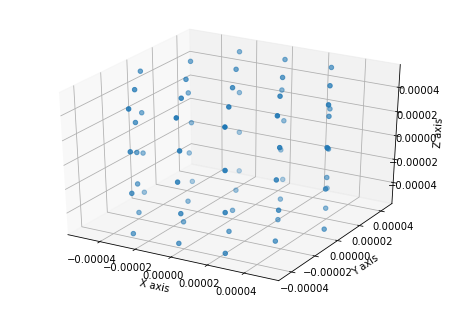

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

for i in range(number_of_scatterers):
    grid = grids[i]
    vertices = grid.leaf_view.vertices
    ax.scatter(vertices[0], vertices[1], vertices[2])

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

In [8]:
def get_memory(number_of_scatterers, operator):
    mem = 0
    for i in range(2*number_of_scatterers):
        for j in range(2*number_of_scatterers):
            op = operator[i][j]
            mem += op.memory
    return mem

The following sets up the necessary spaces, the operator *PMCHWT_op* and the preconditioner *PMCHWT_pre*. The default choice of preconditioner is $\mathbf{D}^i$. For more choices see `operators.py` For more details see the paper by [Kleanthous *et al.* (2020)](https://arxiv.org/pdf/2008.04772.pdf).

In [9]:
# Set spaces
rwg_space = [bempp.api.function_space(grid, 'RWG', 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, 'SNC', 0) for grid in grids]
bc_space = [bempp.api.function_space(grid, 'BC', 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, 'RBC', 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

N = sum([space.global_dof_count for space in rwg_space])
print (N ,'NDOF')

[PMCHWT_op, filter_operators] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_A)

PMCHWT_pre = PMCHWT_preconditioner(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_P)
mass_matrix = mass_matrix_BC_SNC(grids)

t0 = time.time()
pre_sf = PMCHWT_pre.strong_form()
op_wf = PMCHWT_op.weak_form()
cald_op_sf = pre_sf * mass_matrix * op_wf
ta_cald_op_sf = time.time() - t0
print('assembly time: {0:.3f} mins'.format(ta_cald_op_sf/60))
print('memory op: {0:.3f} GB'.format(get_memory(number_of_scatterers, op_wf)/(2*1024**2)))

198 NDOF
assembly time: 0.010 mins
memory op: 0.002 GB


In [10]:
restart = 400
maxiter = 400
tol=1E-5

The next defines the number of angles $\gamma$ (corresponding to polarisation rotations)

In [11]:
N_gauss = 15
[angles_gauss, weights_gamma] = np.polynomial.legendre.leggauss(N_gauss)
weights_gamma = weights_gamma/2
angles_gauss = (2*np.pi)*angles_gauss/2 + (2*np.pi)/2

The next defines the number of angles $\phi$ 

In [12]:
n_averaging = 1
n_waves = n_averaging
[phi_averaging, w_averaging] = np.polynomial.legendre.leggauss(n_averaging)
w_averaging = w_averaging/2
phi_averaging = (2*np.pi)*phi_averaging/2 + (2*np.pi)/2

In [13]:
number_of_angles = 1801

n_leb = 59
coord = np.loadtxt('far_field/PointDistFiles/lebedev/lebedev_0{0}.txt'.format(n_leb))
w_leb = coord[:,2] #weights
phi_leb = np.radians(coord[:,0]) #phi
theta_leb = np.radians(coord[:,1])#theta

The angle $\theta$ needs to be assigned a value in the following cell (theta_inc currently set to $\pi/2$)

In [14]:
def incident_wave_func(counter_gauss, counter_lebedev):

    print(counter_gauss, counter_lebedev)
    x =  angles_gauss[counter_gauss]

    weights = w_averaging[counter_lebedev]
    theta_inc = np.pi/2
    phi_inc = phi_averaging[counter_lebedev]
    


    incident_direction = np.array([np.sin(theta_inc) * np.cos(phi_inc), 
                                   np.sin(theta_inc) * np.sin(phi_inc), 
                                    np.cos(theta_inc)])
    vector_theta_inc = np.array([np.cos(theta_inc) * np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc)*np.sin(x), 
                                 np.cos(theta_inc) * np.sin(phi_inc) * np.cos(x) + np.cos(phi_inc) * np.sin(x), 
                                 -np.sin(theta_inc) * np.cos(x)])
    vector_phi_inc = np.array([-np.sin(phi_inc) * np.cos(x) - np.cos(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                               np.cos(phi_inc) * np.cos(x) - np.sin(phi_inc) * np.cos(theta_inc) * np.sin(x), 
                              np.sin(theta_inc) * np.sin(x)])
   
    def plane_wave_phi(point):
        return vector_phi_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_theta(point):
        return vector_theta_inc * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def dirichlet_trace_phi_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_phi(point), n)

    def dirichlet_trace_theta_inc(point, n, domain_index, result):
        result[:] =  np.cross(plane_wave_theta(point), n)

    def plane_wave_curl_phi(point):
        return np.cross(incident_direction, vector_phi_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def plane_wave_curl_theta(point):
        return np.cross(incident_direction, vector_theta_inc) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, incident_direction))

    def neumann_trace_phi_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_phi(point), n)

    def neumann_trace_theta_inc(point, n, domain_index, result):
        result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl_theta(point), n)
    ##############################################################################
    # sovling for incident field
    ##############################################################################
    incident_dirichlet_phi = []
    incident_neumann_phi = []
    incident_dirichlet_theta = []
    incident_neumann_theta = []

    for i in range(number_of_scatterers):
        incident_dirichlet_phi.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_phi_inc))
        incident_neumann_phi.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_phi_inc))

        incident_dirichlet_theta.append(bempp.api.GridFunction(rwg_space[i], fun = dirichlet_trace_theta_inc))
        incident_neumann_theta.append((k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun=neumann_trace_theta_inc))

    # Set RHS
    rhs_phi = number_of_scatterers * [None]
    rhs_theta = number_of_scatterers * [None]

    for i in range(number_of_scatterers):
        filter_op_wf = filter_operators[i].weak_form()
        rhs_phi[i] = filter_op_wf * (incident_dirichlet_phi[i].coefficients.tolist()+ incident_neumann_phi[i].coefficients.tolist())
        rhs_theta[i] = filter_op_wf * (incident_dirichlet_theta[i].coefficients.tolist() + incident_neumann_theta[i].coefficients.tolist())

    rhs_phi = [y for x in rhs_phi for y in x]
    rhs_theta = [y for x in rhs_theta for y in x]

    rhs_phi = pre_sf * mass_matrix * rhs_phi
    rhs_theta = pre_sf * mass_matrix * rhs_theta

    t0 = time.time()
    x_phi, info_phi, iters_phi = gmres(cald_op_sf, rhs_phi, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_phi = time.time() - t0
    if len(iters_phi) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    t0 = time.time()
    x_theta, info_theta, iters_theta = gmres(cald_op_sf, rhs_theta, tol=tol, restart = restart, maxiter = maxiter, return_residuals = True)
    t_solve_theta = time.time() - t0
    print('{0},{1}:  solver time phi: {2} mins \n iters phi: {3}'.format(counter_gauss, counter_lebedev,t_solve_phi/60, len(iters_phi)))
    print('{0},{1}:  solver time theta: {2} mins \n iters theta: {3}'.format(counter_gauss, counter_lebedev,t_solve_theta/60, len(iters_theta)))
    if len(iters_theta) == maxiter:
        raise ValueError('Maximum number of iterations reached before convergence. Choose a larger maxiter above')

    scattered_dirichlet_exterior_phi = number_of_scatterers * [None]
    scattered_neumann_exterior_phi = number_of_scatterers * [None]

    scattered_dirichlet_exterior_theta = number_of_scatterers * [None]
    scattered_neumann_exterior_theta = number_of_scatterers * [None]

    sum_dofs = 0
    for i in range(number_of_scatterers):
        scattered_dirichlet_exterior_phi[i] = x_phi[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_phi[i] =  (mu_ext / k_ext) *  x_phi[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        scattered_dirichlet_exterior_theta[i] = x_theta[2*sum_dofs: 2*sum_dofs + rwg_space[i].global_dof_count]
        scattered_neumann_exterior_theta[i] =  (mu_ext / k_ext) *  x_theta[2*sum_dofs + rwg_space[i].global_dof_count : 
                                                                   2*sum_dofs + 2*rwg_space[i].global_dof_count]

        sum_dofs += rwg_space[i].global_dof_count

    ###################################################################################
    ## Computing Cext
    ###################################################################################
    far_field_phi = np.zeros((3, 1), dtype='complex128')
    far_field_theta = np.zeros((3, 1), dtype = 'complex128')

    incident_direction = np.array([[np.sin(theta_inc) * np.cos(phi_inc),
                                   np.sin(theta_inc) * np.sin(phi_inc),
                                   np.cos(theta_inc)]])

    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], incident_direction.T, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], incident_direction.T, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta


    
    Cext_phi = 4*np.pi/(k_ext * np.linalg.norm(vector_phi_inc)**2) * np.imag(np.dot(far_field_phi[:,0], np.conjugate(vector_phi_inc)))
    Cext_theta = 4*np.pi/(k_ext * np.linalg.norm(vector_theta_inc)**2) * np.imag(np.dot(far_field_theta[:,0],np.conjugate(vector_theta_inc)))
    Cext = 0.5* (Cext_phi + Cext_theta)
    
    ###################################################################################
    ## Computing Csca
    ###################################################################################
    coord_leb_Csca = np.vstack([np.sin(theta_leb)*np.cos(phi_leb), 
                                np.sin(theta_leb)*np.sin(phi_leb), 
                                np.cos(theta_leb)])
    ff_quad_phi = np.zeros(np.shape(coord_leb_Csca), dtype='complex128')
    ff_quad_theta = np.zeros(np.shape(coord_leb_Csca), dtype = 'complex128')
    bempp.api.global_parameters.assembly.potential_operator_assembly_type = 'dense'

    R_theta = np.array([[np.cos(theta_inc), 0 ,np.sin(theta_inc)], [0,1,0], [-np.sin(theta_inc), 0, np.cos(theta_inc)]])
    R_phi = np.array([[np.cos(phi_inc), -np.sin(phi_inc), 0], [np.sin(phi_inc), np.cos(phi_inc), 0], [0,0,1]])
    R_x = np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0,0,1]])

    beta_matrix = np.dot(R_phi, np.dot(R_theta, R_x))
    coord_leb_Csca = np.dot(beta_matrix, coord_leb_Csca)
    
    for i in range(number_of_scatterers):

        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i], coord_leb_Csca, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i], coord_leb_Csca, k_ext)    

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        ff_quad_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        ff_quad_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta

    ff_quad_phi_mag = np.linalg.norm(ff_quad_phi, axis = 0)**2
    ff_quad_theta_mag = np.linalg.norm(ff_quad_theta, axis = 0)**2

    Int_phi = 4*np.pi * np.dot(ff_quad_phi_mag,w_leb)
    Int_theta = 4*np.pi * np.dot(ff_quad_theta_mag,w_leb)# the 4*np.pi factor comes from the quadrature rule

    Csca_phi = 1/np.linalg.norm(vector_phi_inc)**2 * Int_phi
    Csca_theta = 1/np.linalg.norm(vector_theta_inc)**2 * Int_theta

    Csca = 0.5 * (Csca_phi + Csca_theta)
    w = Csca/Cext
    ############################################################################################
    ## Computing g
    ############################################################################################
    Int_g_phi = 4*np.pi * np.dot(np.dot(incident_direction,coord_leb_Csca)*ff_quad_phi_mag, w_leb)
    Int_g_theta = 4 * np.pi * np.dot(np.dot(incident_direction,coord_leb_Csca)*ff_quad_theta_mag, w_leb)

    g = 0.5/Csca * (Int_g_phi[0] + Int_g_theta[0])
    ##################################################################
    ## Computing phase matrix
    ##################################################################
    far_field_phi = np.zeros((3, number_of_angles), dtype='complex128')
    far_field_theta = np.zeros((3, number_of_angles), dtype = 'complex128')

    angles_theta = np.linspace(0 , 2*np.pi , number_of_angles)
    angles_phi = 0. + phi_inc

    scattering_direction = np.array([np.sin(angles_theta) * np.cos(angles_phi),
                                     np.sin(angles_theta) * np.sin(angles_phi),
                                     np.cos(angles_theta)])
    scattering_direction = np.dot(beta_matrix, scattering_direction)
    
    for i in range(number_of_scatterers):
        electric_far = bempp.api.operators.far_field.maxwell.electric_field(rwg_space[i],scattering_direction, k_ext)
        magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(rwg_space[i],scattering_direction, k_ext)

        sc_N_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_phi[i])
        sc_D_phi = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_phi[i])

        sc_N_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_neumann_exterior_theta[i])
        sc_D_theta = bempp.api.GridFunction(rwg_space[i], coefficients = scattered_dirichlet_exterior_theta[i])

        far_field_phi += -electric_far * sc_N_phi - magnetic_far * sc_D_phi
        far_field_theta += -electric_far * sc_N_theta - magnetic_far * sc_D_theta
    
   
    vector_theta_sca = np.array([np.cos(angles_theta)*np.cos(angles_phi),
                                np.cos(angles_theta)*np.sin(angles_phi),
                                -np.sin(angles_theta)])
    vector_phi_sca = np.array([-np.sin(angles_phi)*np.ones(number_of_angles),
                               np.cos(angles_phi)*np.ones(number_of_angles),
                               np.zeros(number_of_angles)])
    

    vector_theta_sca = np.dot(beta_matrix, vector_theta_sca)
    vector_phi_sca = np.dot(beta_matrix, vector_phi_sca)
    
    a11 = []
    a12 = []
    a21 = []
    a22 = []

    for i in range(number_of_angles):
        a11.append(np.dot(vector_theta_sca[:,i], far_field_theta[:,i]))
        a12.append(np.dot(vector_theta_sca[:,i], far_field_phi[:,i]))
        a21.append(np.dot(vector_phi_sca[:,i], far_field_theta[:,i]))
        a22.append(np.dot(vector_phi_sca[:,i], far_field_phi[:,i]))
    
     
    S11 = np.array(a11)
    S12 = np.array(a12)
    S21 = np.array(a21)
    S22 = np.array(a22)

   
    Z11 = 0.5 * (abs(S11)**2 + abs(S12)**2 + abs(S21)**2 + abs(S22)**2)
    Z12 = 0.5*(abs(S11)**2-abs(S22)**2+abs(S21)**2-abs(S12)**2)
    Z13 = -np.real(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z14 = -np.imag(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z21 = 0.5*(abs(S11)**2-abs(S22)**2-abs(S21)**2+abs(S12)**2)
    Z22 = 0.5*(abs(S11)**2+abs(S22)**2-abs(S21)**2-abs(S12)**2)
    Z23 = -np.real(S11*np.conjugate(S12)-S22*np.conjugate(S21))
    Z24 = -np.imag(S11*np.conjugate(S12)+S22*np.conjugate(S21))
    Z31 = -np.real(S11*np.conjugate(S21)+S22*np.conjugate(S12))
    Z32 = -np.real(S11*np.conjugate(S21)-S22*np.conjugate(S12))
    Z33 = np.real(np.conjugate(S11)*S22+S12*np.conjugate(S21))
    Z34 = np.imag(S11*np.conjugate(S22)+S21*np.conjugate(S12))
    Z41 = -np.imag(np.conjugate(S11)*S21+np.conjugate(S12)*S22)
    Z42 = -np.imag(np.conjugate(S11)*S21-np.conjugate(S12)*S22)
    Z43 = np.imag(S22*np.conjugate(S11)-S12*np.conjugate(S21))
    Z44 = np.real(np.conjugate(S11)*S22-S12*np.conjugate(S21))
    
    Cbsca = Z11[int(number_of_angles/2)] * 4 * np.pi

    return (counter_gauss,counter_lebedev, weights, theta_inc, phi_inc, len(iters_phi), len(iters_theta), t_solve_phi/60, t_solve_theta/60, 
            Cext, Csca, w, g, Cbsca, Z11, Z12, Z13, Z14, Z21, Z22, Z23, Z24, Z31, Z32, Z33, Z34, Z41, Z42, Z43, Z44)

In [15]:
starttime = time.time()
if __name__ == '__main__':
    p = Pool(processes = cpu_count())
    a = p.starmap(incident_wave_func, [(counter_gauss,counter_lebedev) for counter_gauss in range(N_gauss) for counter_lebedev in range(np.shape(w_averaging)[0])])
    p.close()
    p.join()
endtime = time.time()
print('Total time: {0} mins'.format((endtime - starttime)/60))
print('-------------------------------------------------------------------')

2 0
1 0
0 0
3 0
5 0
6 0
4 0
7 0
8 0
9 0
10 0
11 0
12 0
14 0
13 0
10,0:  solver time phi: 0.008850383758544921 mins 
 iters phi: 109,0:  solver time phi: 0.008850383758544921 mins 
 iters phi: 10

10,0:  solver time theta: 0.009278333187103272 mins 
 iters theta: 11
9,0:  solver time theta: 0.009278333187103272 mins 
 iters theta: 11
3,0:  solver time phi: 0.009699515501658122 mins 
 iters phi: 111,0:  solver time phi: 0.010740923881530761 mins 
 iters phi: 117,0:  solver time phi: 0.009291632970174154 mins 
 iters phi: 104,0:  solver time phi: 0.009290496508280436 mins 
 iters phi: 10



3,0:  solver time theta: 0.009301737944285075 mins 
 iters theta: 111,0:  solver time theta: 0.008479698499043783 mins 
 iters theta: 104,0:  solver time theta: 0.009474273522694905 mins 
 iters theta: 117,0:  solver time theta: 0.009472966194152832 mins 
 iters theta: 10



5,0:  solver time phi: 0.00973584254582723 mins 
 iters phi: 10
5,0:  solver time theta: 0.009820139408111573 mins 
 iters theta:

In [16]:
weights_averaging = []
theta_inc = []
phi_inc = []
iterations_theta = []
iterations_phi = []
solver_time_phi = []
solver_time_theta = []
Cext = []
Csca = []
Cbsca = []
g = []
w = []
Z11 = []
Z12 = []
Z13 = []
Z14 = []
Z21 = []
Z22 = []
Z23 = []
Z24 = []
Z31 = []
Z32 = []
Z33 = []
Z34 = []
Z41 = []
Z42 = []
Z43 = []
Z44 = []

a.sort(key=lambda element: (element[0], element[1]) )

weights_averaging.append([r[2] for r in a])
theta_inc.append([r[3] for r in a])
phi_inc.append([r[4] for r in a])
iterations_theta.append([r[6] for r in a])
iterations_phi.append([r[5] for r in a])
solver_time_phi.append([r[7] for r in a])
solver_time_theta.append([r[8] for r in a])
Cext.append([r[9] for r in a])
Csca.append([r[10] for r in a])
w.append([r[11] for r in a])
g.append([r[12] for r in a])
Cbsca.append([r[13] for r in a])
Z11.append([r[14] for r in a])
Z12.append([r[15] for r in a])
Z13.append([r[16] for r in a])
Z14.append([r[17] for r in a])
Z21.append([r[18] for r in a])
Z22.append([r[19] for r in a])
Z23.append([r[20] for r in a])
Z24.append([r[21] for r in a])
Z31.append([r[22] for r in a])
Z32.append([r[23] for r in a])
Z33.append([r[24] for r in a])
Z34.append([r[25] for r in a])
Z41.append([r[26] for r in a])
Z42.append([r[27] for r in a])
Z43.append([r[28] for r in a])
Z44.append([r[29] for r in a])

In [17]:
Cext = np.reshape(np.array(Cext[0]), (N_gauss, n_waves))
Csca = np.reshape(np.array(Csca[0]), (N_gauss, n_waves))
Cbsca = np.reshape(np.array(Cbsca[0]), (N_gauss, n_waves))
g = np.reshape(np.array(g[0]), (N_gauss, n_waves))
w = np.reshape(np.array(w[0]), (N_gauss, n_waves))

Cext_avg = np.dot(weights_gamma,np.dot(Cext, w_averaging))
Csca_avg = np.dot(weights_gamma,np.dot(Csca, w_averaging))
Cbsca_avg = np.dot(weights_gamma,np.dot(Cbsca, w_averaging))
g_avg = np.dot(weights_gamma,np.dot(g, w_averaging))
w_avg = np.dot(weights_gamma,np.dot(w, w_averaging))

print("Error in Csca: {0:.3%}".format(abs(Csca_avg - Csca_Tmatrix)/Csca_Tmatrix))
print("Error in Cext: {0:.3%}".format(abs(Cext_avg - Cext_Tmatrix)/Cext_Tmatrix))
print("Error in Cbsca: {0:.3%}".format(abs(Cbsca_avg - Cbsca_Tmatrix)/Cbsca_Tmatrix))
print("Error in g: {0:.3%}".format(abs(g_avg - g_Tmatrix)/g_Tmatrix))
print("Error in w: {0:.3%}".format(abs(w_avg - w_Tmatrix)/w_Tmatrix))

Error in Csca: 0.003%
Error in Cext: 0.168%
Error in Cbsca: 0.252%
Error in g: 1.719%
Error in w: 0.171%


In [18]:
Z11 = np.transpose(np.reshape(np.array(Z11[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z12 = np.transpose(np.reshape(np.array(Z12[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z13 = np.transpose(np.reshape(np.array(Z13[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z14 = np.transpose(np.reshape(np.array(Z14[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z21 = np.transpose(np.reshape(np.array(Z21[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z22 = np.transpose(np.reshape(np.array(Z22[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z23 = np.transpose(np.reshape(np.array(Z23[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z24 = np.transpose(np.reshape(np.array(Z24[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z31 = np.transpose(np.reshape(np.array(Z31[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z32 = np.transpose(np.reshape(np.array(Z32[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z33 = np.transpose(np.reshape(np.array(Z33[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z34 = np.transpose(np.reshape(np.array(Z34[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z41 = np.transpose(np.reshape(np.array(Z41[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z42 = np.transpose(np.reshape(np.array(Z42[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z43 = np.transpose(np.reshape(np.array(Z43[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))
Z44 = np.transpose(np.reshape(np.array(Z44[0]), (N_gauss, n_waves, number_of_angles)), axes = (0,2,1))

In [19]:
Z11_avg = np.dot(weights_gamma, np.dot(Z11, w_averaging))
Z12_avg = np.dot(weights_gamma, np.dot(Z12, w_averaging))
Z13_avg = np.dot(weights_gamma, np.dot(Z13, w_averaging))
Z14_avg = np.dot(weights_gamma, np.dot(Z14, w_averaging))
Z21_avg = np.dot(weights_gamma, np.dot(Z21, w_averaging))
Z22_avg = np.dot(weights_gamma, np.dot(Z22, w_averaging))
Z23_avg = np.dot(weights_gamma, np.dot(Z23, w_averaging))
Z24_avg = np.dot(weights_gamma, np.dot(Z24, w_averaging))
Z31_avg = np.dot(weights_gamma, np.dot(Z31, w_averaging))
Z32_avg = np.dot(weights_gamma, np.dot(Z32, w_averaging))
Z33_avg = np.dot(weights_gamma, np.dot(Z33, w_averaging))
Z34_avg = np.dot(weights_gamma, np.dot(Z34, w_averaging))
Z41_avg = np.dot(weights_gamma, np.dot(Z41, w_averaging))
Z42_avg = np.dot(weights_gamma, np.dot(Z42, w_averaging))
Z43_avg = np.dot(weights_gamma, np.dot(Z43, w_averaging))
Z44_avg = np.dot(weights_gamma, np.dot(Z44, w_averaging))

The following evaluates $C_{sca}$ and $g$ from the Z11 phase matrix element and compares with T-matrix results

In [20]:
Z11_Csca = np.dot(np.sin(np.linspace(0, np.pi, int(number_of_angles/2))), Z11_avg[0:int(number_of_angles/2)])*np.pi**2*2/(number_of_angles/2)
print("Error in Csca: {0:.5%}".format(abs(Z11_Csca - Csca_Tmatrix)/Csca_Tmatrix))
print("Csca_BEM: {0} \n Csca_Z11: {1} \n Csca_Tmatrix: {2}".format(Csca_avg, Z11_Csca, Csca_Tmatrix))
print('--------------------')

Z11_g = np.dot(np.sin(np.linspace(0, np.pi, int(number_of_angles/2)))*np.cos(np.linspace(0, np.pi, int(number_of_angles/2))), 
               Z11_avg[0:int(number_of_angles/2)])*np.pi**2*2/(number_of_angles/2*Csca_avg)
print("Error in g: {0:.5%}".format(abs(Z11_g - g_Tmatrix)/g_Tmatrix))
print("g_BEM: {0} \n g_Z11: {1} \n g_Tmatrix: {2}".format(g_avg, Z11_g, g_Tmatrix))

Error in Csca: 0.15377%
Csca_BEM: 1.765448763676828e-09 
 Csca_Z11: 1.7626799733673142e-09 
 Csca_Tmatrix: 1.76539457556903e-09
--------------------
Error in g: 1.94057%
g_BEM: 0.11298930005646174 
 g_Z11: 0.11323516554395908 
 g_Tmatrix: 0.11107958459421


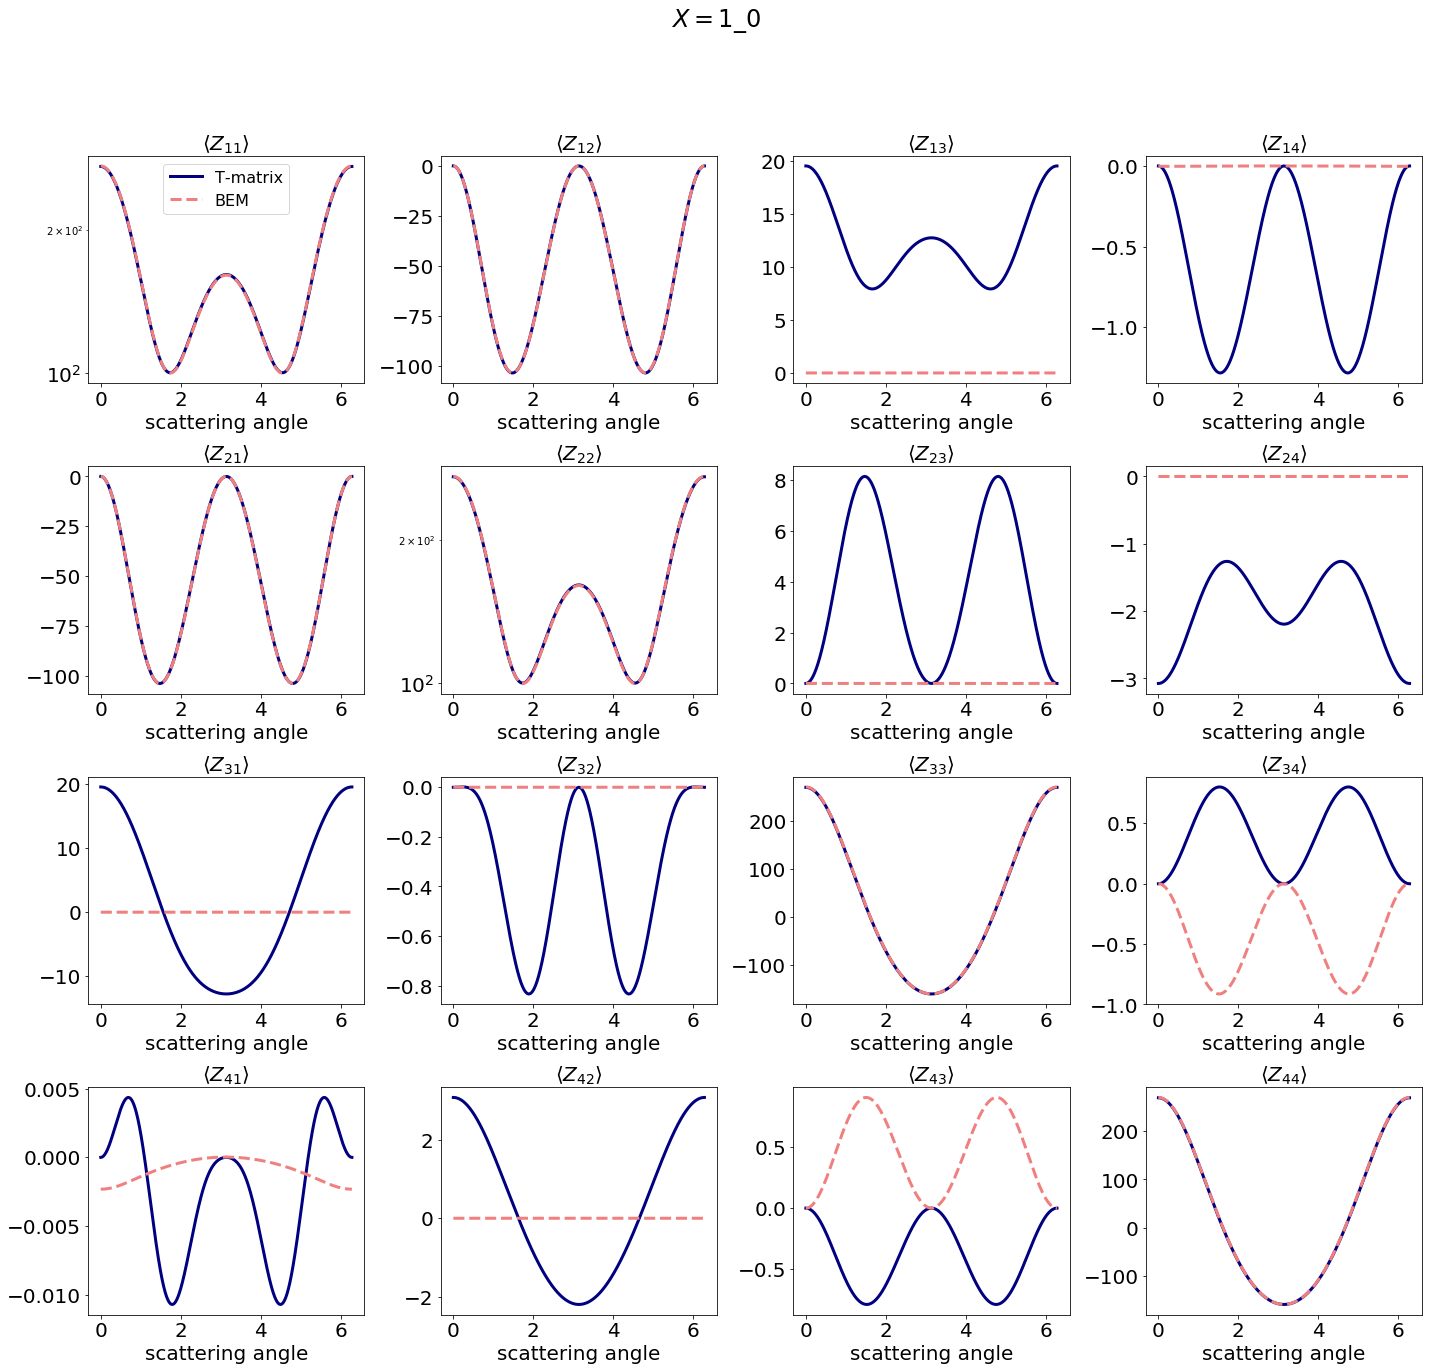

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
scaling = 1E12
angles_theta = np.linspace(0,2*np.pi,number_of_angles)

fig, axs = plt.subplots(4, 4, figsize = (20,20))
axs[0, 0].semilogy(Tmatrix_coords, Z11_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[0, 0].semilogy(angles_theta, scaling*Z11_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[0, 0].set_title(r'$\langle Z_{11} \rangle$', fontsize = 20)
axs[0, 0].legend(fontsize = 16)
axs[0, 0].set_xlabel('scattering angle', fontsize = 20)
axs[0, 0].tick_params(axis = 'both', labelsize = 20)

axs[0, 1].plot(Tmatrix_coords, Z12_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[0, 1].plot(angles_theta, scaling*Z12_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[0, 1].set_title(r'$\langle Z_{12} \rangle$', fontsize = 20)
axs[0, 1].set_xlabel('scattering angle', fontsize = 20)
axs[0, 1].tick_params(axis = 'both', labelsize = 20)

axs[0, 2].plot(Tmatrix_coords, Z13_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[0, 2].plot(angles_theta, scaling*Z13_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[0, 2].set_title(r'$\langle Z_{13} \rangle$', fontsize = 20)
axs[0, 2].set_xlabel('scattering angle', fontsize = 20)
axs[0, 2].tick_params(axis = 'both', labelsize = 20)

axs[0, 3].plot(Tmatrix_coords, Z14_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[0, 3].plot(angles_theta, scaling*Z14_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[0, 3].set_title(r'$\langle Z_{14} \rangle$', fontsize = 20)
axs[0, 3].set_xlabel('scattering angle', fontsize = 20)
axs[0, 3].tick_params(axis = 'both', labelsize = 20)

axs[1, 0].plot(Tmatrix_coords, Z21_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[1, 0].plot(angles_theta, scaling*Z21_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[1, 0].set_title(r'$\langle Z_{21} \rangle$', fontsize = 20)
axs[1, 0].set_xlabel('scattering angle', fontsize = 20)
axs[1, 0].tick_params(axis = 'both', labelsize = 20)

axs[1, 1].semilogy(Tmatrix_coords, Z22_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[1, 1].semilogy(angles_theta, scaling*Z22_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[1, 1].set_title(r'$\langle Z_{22} \rangle$', fontsize = 20)
axs[1, 1].set_xlabel('scattering angle', fontsize = 20)
axs[1, 1].tick_params(axis = 'both', labelsize = 20)

axs[1, 2].plot(Tmatrix_coords, Z23_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[1, 2].plot(angles_theta, scaling*Z23_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[1, 2].set_title(r'$\langle Z_{23} \rangle$', fontsize = 20)
axs[1, 2].set_xlabel('scattering angle', fontsize = 20)
axs[1, 2].tick_params(axis = 'both', labelsize = 20)

axs[1, 3].plot(Tmatrix_coords, Z24_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[1, 3].plot(angles_theta, scaling*Z24_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[1, 3].set_title(r'$\langle Z_{24} \rangle$', fontsize = 20)
axs[1, 3].set_xlabel('scattering angle', fontsize = 20)
axs[1, 3].tick_params(axis = 'both', labelsize = 20)

axs[2, 0].plot(Tmatrix_coords, Z31_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[2, 0].plot(angles_theta,scaling* Z31_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[2, 0].set_title(r'$\langle Z_{31} \rangle$', fontsize = 20)
axs[2, 0].set_xlabel('scattering angle', fontsize = 20)
axs[2, 0].tick_params(axis = 'both', labelsize = 20)

axs[2, 1].plot(Tmatrix_coords, Z32_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[2, 1].plot(angles_theta,scaling* Z32_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[2, 1].set_title(r'$\langle Z_{32} \rangle$', fontsize = 20)
axs[2, 1].set_xlabel('scattering angle', fontsize = 20)
axs[2, 1].tick_params(axis = 'both', labelsize = 20)

axs[2, 2].plot(Tmatrix_coords, Z33_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[2, 2].plot(angles_theta,scaling* Z33_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[2, 2].set_title(r'$\langle Z_{33} \rangle$', fontsize = 20)
axs[2, 2].set_xlabel('scattering angle', fontsize = 20)
axs[2, 2].tick_params(axis = 'both', labelsize = 20)

axs[2, 3].plot(Tmatrix_coords, Z34_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[2, 3].plot(angles_theta,scaling* Z34_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[2, 3].set_title(r'$\langle Z_{34} \rangle$', fontsize = 20)
axs[2, 3].set_xlabel('scattering angle', fontsize = 20)
axs[2, 3].tick_params(axis = 'both', labelsize = 20)

axs[3, 0].plot(Tmatrix_coords, Z41_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[3, 0].plot(angles_theta,scaling* Z41_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[3, 0].set_title(r'$\langle Z_{41} \rangle$', fontsize = 20)
axs[3, 0].set_xlabel('scattering angle', fontsize = 20)
axs[3, 0].tick_params(axis = 'both', labelsize = 20)

axs[3, 1].plot(Tmatrix_coords, Z42_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[3, 1].plot(angles_theta,scaling* Z42_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[3, 1].set_title(r'$\langle Z_{42} \rangle$', fontsize = 20)
axs[3, 1].set_xlabel('scattering angle', fontsize = 20)
axs[3, 1].tick_params(axis = 'both', labelsize = 20)

axs[3, 2].plot(Tmatrix_coords, Z43_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[3, 2].plot(angles_theta,scaling* Z43_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[3, 2].set_title(r'$\langle Z_{43} \rangle$', fontsize = 20)
axs[3, 2].set_xlabel('scattering angle', fontsize = 20)
axs[3, 2].tick_params(axis = 'both', labelsize = 20)

axs[3, 3].plot(Tmatrix_coords, Z44_Tmatrix, 'navy', linewidth=3, label = 'T-matrix')
axs[3, 3].plot(angles_theta,scaling* Z44_avg, '--',color ='lightcoral', linewidth=3, label = 'BEM')
axs[3, 3].set_title(r'$\langle Z_{44} \rangle$', fontsize = 20)
axs[3, 3].set_xlabel('scattering angle', fontsize = 20)
axs[3, 3].tick_params(axis = 'both', labelsize = 20)

plt.suptitle(r'$X = $' + X, fontsize = 24)
plt.tight_layout(rect=[0, 0.03, 1, 0.9])